In [12]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

In [13]:
device = torch.device("mps")
cachedir = './cache'

In [14]:
# Load the model and tokenizer
model_name = "osunlp/TableLlama"  # Replace with your model

config = transformers.AutoConfig.from_pretrained(
    model_name,
    cache_dir=cachedir,
)

orig_ctx_len = getattr(config, "max_position_embeddings", None)
        
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             cache_dir=cachedir, 
                                             torch_dtype=torch.float16).to(device)
model.resize_token_embeddings(32001)

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                         cache_dir=cachedir,
                                         model_max_length=orig_ctx_len,
                                         padding_side="left",
                                         use_fast=False
                                         )
model.eval()

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.75s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [133]:
torch.__version__

'2.4.1'

In [5]:
#import sys
#if torch.__version__ >= "2" and sys.platform != "win32":
#    model = torch.compile(model)

In [15]:
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    if input:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

instruction = """This is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical."""
input_seg = """[TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 |"""
question = """How much is the total research of department of defense in 2014?"""

prompt = generate_prompt(instruction, question, input_seg)

In [16]:
prompt

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nThis is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical.\n\n### Input:\n[TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 |\n\n### Question:\nHow much is the total research of department of defense in 2014?\n\n### Response:'

In [17]:
%%time

temperature=1.
top_p=1.0
max_gen_len=4096
use_cache=True

inputs = tokenizer(prompt, return_tensors="pt").to(device)

CPU times: user 1.98 ms, sys: 5.59 ms, total: 7.57 ms
Wall time: 6.61 ms


In [18]:
%%time
# pre
if False:
    
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True

    with torch.no_grad():
        pre_outputs = model(**inputs)
        pre_logits = pre_outputs.logits

    # Get the logits for the last token in the sequence
    last_token_logits = pre_logits[0, -1, :]  # Shape: (vocab_size,)

    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(last_token_logits, dim=-1)  # Shape: (vocab_size,)

    # Sort tokens by probability (optional)
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
    for idx, prob in zip(sorted_indices[:10], sorted_probs[:10]):
        print(f"Token: {tokenizer.decode(idx)}, Probability: {prob.item():.4f}")

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [19]:
%%time
# post
output = model.generate(
            **inputs,
            max_new_tokens=max_gen_len,
            temperature=temperature,
            top_p=top_p,
            use_cache=use_cache,
            output_scores=True, 
            return_dict_in_generate=True,
        )

CPU times: user 426 ms, sys: 4.53 s, total: 4.96 s
Wall time: 5.31 s


In [26]:
inputs['input_ids'].shape

torch.Size([1, 326])

In [21]:
with torch.no_grad():
    pre_outputs = model(**inputs)
    pre_logits = pre_outputs.logits

In [28]:
!pwd

/Users/bono/Library/CloudStorage/OneDrive-PolitecnicodiMilano/work/prin


In [24]:
pre_outputs.logits.shape

torch.Size([1, 326, 32001])

In [174]:
[tokenizer.convert_ids_to_tokens(token_id.item()) for token_id in output.sequences[0][-7:]]

['6', '6', '9', '1', '.', '5', '</s>']

In [167]:
tokenizer.decode(])

'6691.5</s>'

In [164]:
out = tokenizer.decode(output.sequences[0], skip_special_tokens=False, clean_up_tokenization_spaces=False)
out = out.split(prompt)[1].strip()
out

'6691.5</s>'

In [140]:
logits = output.scores
probabilities = [F.softmax(logits, dim=-1) for logits in output.scores]

# Decode the generated sequence
generated_ids = output.sequences  # The token IDs of the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [141]:
generated_text

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nThis is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical.\n\n### Input:\n[TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 |\n\n### Question:\nHow much is the total research of department of defense in 2014?\n\n### Response:6691.5'

In [142]:
import numpy as np
from scipy.stats import entropy
base = 2  
baseid = len(inputs["input_ids"][0])

# np.log2(50257) max entropy is log2(k)
print("max: ", np.log2(len(probabilities[0].cpu()[0].tolist())))

for i, p in enumerate(probabilities):
    H = entropy(p.cpu()[0].tolist(), base=base)
    print(i,tokenizer.decode(generated_ids[0][baseid + i]),H)

max:  14.965829368177689
0 6 0.2948727698228573
1 6 0.058249834148013165
2 9 0.000351548211692975
3 1 0.00022573423394653156
4 . 0.0006037083243222811
5 5 0.005472745012040451
6 </s> 4.131668463594859e-06


In [143]:
import numpy as np
from scipy.stats import entropy
base = 2  
baseid = len(inputs["input_ids"][0])

# np.log2(50257) max entropy is log2(k)

for i, p in enumerate(probabilities):
    H = entropy(p.cpu()[0].tolist(), base=base)
    print(i,tokenizer.decode(generated_ids[0][baseid + i]),H)

0 6 0.2948727698228573
1 6 0.058249834148013165
2 9 0.000351548211692975
3 1 0.00022573423394653156
4 . 0.0006037083243222811
5 5 0.005472745012040451
6 </s> 4.131668463594859e-06


In [144]:
%%time

# many times

oo = []

for i in range(100):
    print(i, end='\r')
    oo.append(model.generate(
            **inputs,
            max_new_tokens=max_gen_len,
            temperature=temperature,
            top_p=top_p,
            use_cache=use_cache,
            output_scores=True, 
            return_dict_in_generate=True,
        ))

CPU times: user 1min 13s, sys: 38.9 s, total: 1min 52s
Wall time: 3min 48s


In [145]:
ooo = []
probs = []
gids = [] 
for o in oo:
    out = tokenizer.decode(o.sequences[0], skip_special_tokens=False, clean_up_tokenization_spaces=False)
    ooo.append(out.split(prompt)[1].strip())    
    probs.append([F.softmax(logits, dim=-1) for logits in o.scores])
    gids.append(o.sequences[0])

In [146]:
(F.softmax(o.scores[0], dim=-1)>0).sum()

tensor(50, device='mps:0')

In [147]:
len(ooo)

100

In [148]:
from collections import Counter
Counter(ooo)

Counter({'6691.5</s>': 94, '7152.0</s>': 5, '7652.7</s>': 1})

In [149]:
len(generated_ids[0])

333

In [150]:
dfout = []

baseid = len(inputs["input_ids"][0])

c = 0
for out, prob in zip(ooo,probs):
    c += 1
    for i, p in enumerate(prob):
        H = entropy(p.cpu()[0].tolist(), base=base)
        
        tok = tokenizer.decode(generated_ids[0][baseid+i-1])
        
        case = True if out == '6691.5</s>' else False
        
        dfout.append((c,case,i,tok,H))
        # print(i,H)
        # print(i,tokenizer.decode(generated_ids[0][baseid + i]),H)

In [151]:
import pandas as pd

d = pd.DataFrame(dfout, columns=['idx', 'correct', 'i', 'tok', 'H'])

In [152]:
d[:10]

,idx,correct,i,tok,H
0,1,True,0,:,0.294873
1,1,True,1,6,0.058250
2,1,True,2,6,0.000352
3,1,True,3,9,0.000226
4,1,True,4,1,0.000604
5,1,True,5,.,0.005473
6,1,True,6,5,0.000004
7,2,True,0,:,0.294873
8,2,True,1,6,0.058250
9,2,True,2,6,0.000352


In [153]:
d.describe(include='all')

,idx,correct,i,tok,H
count,700.000000,700,700.00000,700,7.000000e+02
unique,NaN,2,NaN,6,NaN
top,NaN,True,NaN,6,NaN
freq,NaN,658,NaN,200,NaN
mean,50.500000,NaN,3.00000,NaN,5.707786e-02
std,28.886711,NaN,2.00143,NaN,1.145226e-01
min,1.000000,NaN,0.00000,NaN,2.872261e-07
25%,25.750000,NaN,1.00000,NaN,2.257342e-04
50%,50.500000,NaN,3.00000,NaN,6.037083e-04
75%,75.250000,NaN,5.00000,NaN,5.824983e-02


In [154]:
d.correct.value_counts(normalize=True)

correct
True     0.94
False    0.06
Name: proportion, dtype: float64

TypeError: bxp() got an unexpected keyword argument 'border'

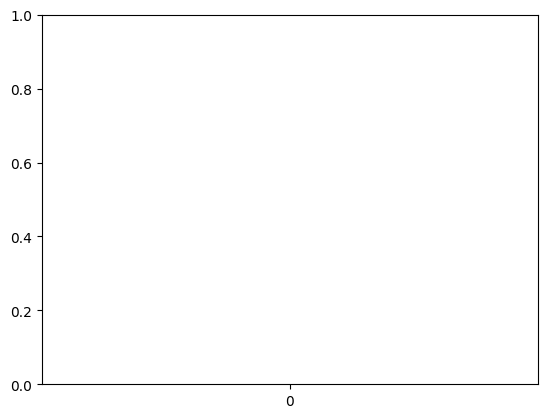

In [158]:
import seaborn as sns

flierprops = {
    'marker': 'o',       # Circle marker
    'markersize': 2,    # Radius of the outliers
    'linestyle': 'none'  # No connecting lines
}

sns.boxplot(data=d, x="i", y="H", hue="correct", linewidth=2, palette='prism_r', flierprops=flierprops)

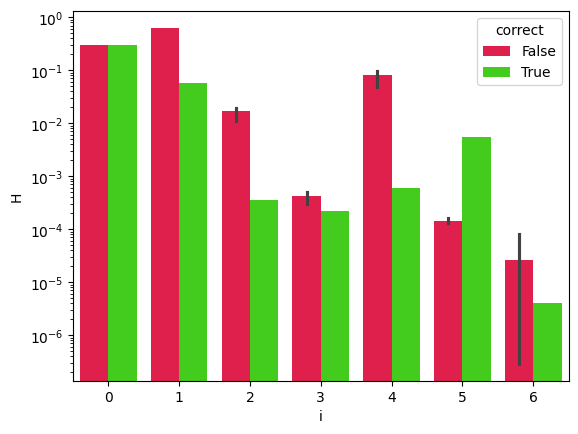

In [161]:
g = sns.barplot(data=d, x="i", y="H", hue="correct", palette='prism_r')
g.set_yscale("log")

In [162]:

# Generate logits
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, sequence_length, vocab_size)

BackendCompilerFailed: backend='inductor' raised:
AssertionError: Device mps not supported

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [117]:
d[d.i==1]

,idx,correct,i,tok,H
1,1,True,1,6,0.313418
8,2,True,1,6,0.313418
15,3,True,1,6,0.313418
22,4,True,1,6,0.313418
29,5,True,1,6,0.313418
...,...,...,...,...,...
673,96,True,1,6,0.313418
680,97,True,1,6,0.313418
687,98,True,1,6,0.313418
694,99,True,1,6,0.313418


<Axes: xlabel='i', ylabel='H'>

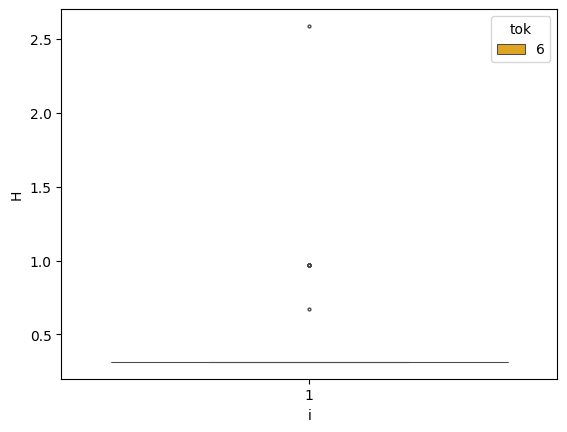

In [116]:
import seaborn as sns

flierprops = {
    'marker': 'o',       # Circle marker
    'markersize': 2,    # Radius of the outliers
    'linestyle': 'none'  # No connecting lines
}

sns.boxplot(data=d[d.i==1], x="i", y="H", hue="tok",  linewidth=0.75, palette='prism_r', flierprops=flierprops)

In [ ]:
# Prepare input
# text = "The quick brown fox"
# text = "This is an entity linking task. The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base. You will be given a list of referent entities, with each one composed of an entity name, its description and its type. Please choose the correct one from the referent entity candidates. Note that the Wikipedia page, Wikipedia section and table caption (if any) provide important information for choosing the correct referent entity."

text = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction: This is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical.

### Input: [TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 | [SEP] | defense advanced research projects agency | defense advanced research projects agency | defense advanced research projects agency | ...

### Question: How many dollars are the difference for total research of department of the air force increase between 2016 and 2018?

### Response:
"""


In [48]:
%%time

inputs = tokenizer(text, return_tensors="pt").to(device)

# Generate logits
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, sequence_length, vocab_size)

CPU times: user 203 ms, sys: 12.9 s, total: 13.1 s
Wall time: 13.2 s


In [49]:
logits.shape

torch.Size([1, 365, 32001])

In [50]:
# Get the logits for the last token in the sequence
last_token_logits = logits[0, -1, :]  # Shape: (vocab_size,)

# Apply softmax to convert logits to probabilities
probabilities = F.softmax(last_token_logits, dim=-1)  # Shape: (vocab_size,)

# Sort tokens by probability (optional)
sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
for idx, prob in zip(sorted_indices[:10], sorted_probs[:10]):
    print(f"Token: {tokenizer.decode(idx)}, Probability: {prob.item():.4f}")

Token: 1, Probability: 0.3870
Token: 3, Probability: 0.1690
Token: 7, Probability: 0.1579
Token: 2, Probability: 0.1535
Token: 4, Probability: 0.0550
Token: 5, Probability: 0.0277
Token: 0, Probability: 0.0235
Token: 6, Probability: 0.0132
Token: 9, Probability: 0.0079
Token: 8, Probability: 0.0049


In [51]:
# Get the predicted token IDs (argmax over logits)
#predicted_token_ids = torch.argmax(logits, dim=-1)  # Shape: (batch_size, sequence_length)

# Decode the predicted tokens to text
#predicted_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

#print(f"Input Text: {text}")
#print(f"Generated Text: {predicted_text}")

In [55]:
%%time

generated_ids = model.generate(inputs["input_ids"], max_new_tokens=50)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(f"Generated Text: {generated_text}")

Generated Text: Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
This is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical.

### Input:
[TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 | [SEP] | defense advanced research projects agency | defense advanced research projects agency | defense advanced research projects agency | ...

### Ques

In [58]:
%%time

# Generate text while capturing logits
output = model.generate(
    inputs["input_ids"],
    max_new_tokens=50,
    output_scores=True,  # Enables logits output
    return_dict_in_generate=True,  # Returns a structured dictionary
)

# he final logits correspond to the step where no token is generated yet, but the model predicts the next token if further generation were to continue
logits = output.scores
probabilities = [F.softmax(logits, dim=-1) for logits in output.scores]

# Decode the generated sequence
generated_ids = output.sequences  # The token IDs of the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

CPU times: user 367 ms, sys: 20.2 s, total: 20.5 s
Wall time: 20.8 s


In [59]:
generated_text

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nThis is a hierarchical table question answering task. The goal for this task is to answer the given question based on the given table. The table might be hierarchical.\n\n### Input:\n[TLE] The table caption is department of defense obligations for research, development, test, and evaluation, by agency: 2015-18. [TAB] | agency | 2015 | 2016 | 2017 | 2018 | [SEP] | department of defense | department of defense | department of defense | department of defense | department of defense | [SEP] | rdt&e | 61513.5 | 69306.1 | 70866.1 | 83725 | [SEP] | total research | 6691.5 | 7152 | 7178 | 7652.7 | [SEP] | basic research | 2133.4 | 2238.7 | 2110.1 | 2389.9 | [SEP] | defense advanced research projects agency | defense advanced research projects agency | defense advanced research projects agency | ...\n\n### Question:\n

In [32]:
len(output.scores)

1

In [33]:
generated_ids.shape

torch.Size([1, 98])

In [34]:
inputs["input_ids"]

tensor([[    1,   910,   338,   385,  7855, 25236,  3414, 29889,   450,  7306,
           363,   445,  3414,   338,   304,  1544,   278,  4629,  7855,  3585,
           297,   278,  1591,  9101,   304,   278,  7855,   297,   278,  7134,
          2967, 29889,   887,   674,   367,  2183,   263,  1051,   310,  2737,
           296, 16212, 29892,   411,  1269,   697, 13725,   310,   385,  7855,
          1024, 29892,   967,  6139,   322,   967,  1134, 29889,  3529,  6755,
           278,  1959,   697,   515,   278,  2737,   296,  7855, 21669, 29889,
          3940,   393,   278, 14109,  1813, 29892, 14109,  4004,   322,  1591,
          5777,   683,   313,   361,   738, 29897,  3867,  4100,  2472,   363,
         23906,   278,  1959,  2737,   296,  7855, 29889]], device='mps:0')

In [23]:
generated_ids

tensor([[    1,   910,   338,   385,  7855, 25236,  3414, 29889,   450,  7306,
           363,   445,  3414,   338,   304,  1544,   278,  4629,  7855,  3585,
           297,   278,  1591,  3729, 29879,   304,   278,  7855,   297,   278,
          7134,  2967, 29889,   887,   674,   367,  2183,   263,  1051,   310,
          2737,   296, 16212, 29892,   411,  1269,   697, 13725,   310,   385,
         10041,  1024, 29892,   967,  6139,   322,   967,  1134, 29889,  3529,
          6755,   278,  1959,   697,   515,   278,  2737,   296,  7855, 21669,
         29889,  3940,   393,   278,  5653,  4652,  1813, 29892, 14109,  4004,
           322,  1591,  5777,   683,   313,   361,   738, 29897,  3867,  4100,
          2472,   363, 23906,   278,  1959, 20275,   296,  7855, 29889,     2]],
       device='mps:0')

In [24]:
tokenizer.decode(284)

'al'

In [25]:
logits[5]

IndexError: tuple index out of range

In [ ]:
probabilities[5].sum()

In [36]:
generated_text

'This is an entity linking task. The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base. You will be given a list of referent entities, with each one composed of an entity name, its description and its type. Please choose the correct one from the referent entity candidates. Note that the Wikipedia page, Wikipedia section and table caption (if any) provide important information for choosing the correct referent entity.'

In [99]:
inputs["input_ids"]

tensor([[  464,  2068,  7586, 21831]], device='mps:0')

In [102]:
import numpy as np
from scipy.stats import entropy
base = 2  
baseid = len(inputs["input_ids"][0]) + 1

# np.log2(50257) max entropy is log2(k)

for i, p in enumerate(probabilities):
    H = entropy(p.cpu()[0].tolist(), base=base)
    print(i,tokenizer.decode(generated_ids[0][baseid + i]),H)

0  are 8.671192238080845
1  a 7.873705631269361
2  great 9.30360883342202
3  way 9.1338864782804
4  to 8.352703089963345
5  get 0.5559380825689656
6  a 8.24432621750076
7  little 6.699689408947498
8  bit 8.35156217411835
9  of 9.638314005800941
10  a 2.6272485624214434
11  kick 8.992072043287184
12  out 9.042737687693931
13  of 1.9051182005587253
14  your 0.3278511804190156
15  dog 6.4998987521189235
16 . 10.867528731834296
17 
 4.362512991988081
18 
 6.6616215800575524
19 The 0.12881022850422472
20  quick 8.787906906305556
21  brown 9.924459095471603
22  fox 0.6108661784739402
23 es 0.5104284333481621
24  are 0.6440794111189311


IndexError: index 30 is out of bounds for dimension 0 with size 30